# Neural Network & KMeans Clustering for Mortality-War Hypothesis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Neural Network & KMeans Hypothesis Modeling

## 1. Load and Prepare Data
!pip install keras-tuner

## __Data Importation and Preprocessing__

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/System/S00-My classes/IE565/Project 2/New folder/unique_cm.csv")
df_cleaned = df[['Entity', 'Year', 'Mortality_Rate',
                 'At war']].copy()
df_cleaned['Mortality_Rate'] = pd.to_numeric(df_cleaned['Mortality_Rate'], errors='coerce')
df_cleaned.dropna(inplace=True)

X = df_cleaned[['Mortality_Rate', 'Year']].values
y = df_cleaned['At war'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


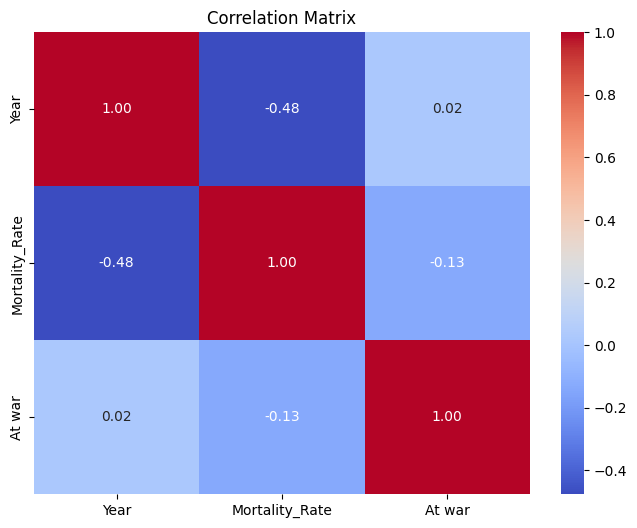

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## __Model1 Building with Class Weight Implementation__

In [9]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Choice('units1', [64, 128, 256]),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Optionally add second hidden layer
    if hp.Boolean('use_second_layer'):
        model.add(Dense(
            units=hp.Choice('units2', [32, 64, 128]),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
# Compute class weights before tuner search
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='hyperband_dir',
    project_name='mortality_war_modeling'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Trial 7 Complete [00h 01m 05s]
val_accuracy: 0.5570545196533203

Best val_accuracy So Far: 0.610455334186554
Total elapsed time: 00h 05m 35s


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for key in best_hps.values.keys():
    print(f"{key}: {best_hps.get(key)}")


Best hyperparameters:
units1: 64
dropout1: 0.30000000000000004
use_second_layer: True
learning_rate: 4.766464679718884e-05
units2: 32
dropout2: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)


Epoch 1/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5760 - loss: 0.6904 - val_accuracy: 0.5391 - val_loss: 0.6779
Epoch 2/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5354 - loss: 0.6930 - val_accuracy: 0.5402 - val_loss: 0.6797
Epoch 3/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5424 - loss: 0.6870 - val_accuracy: 0.5385 - val_loss: 0.6808
Epoch 4/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5132 - loss: 0.6933 - val_accuracy: 0.5357 - val_loss: 0.6810
Epoch 5/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5285 - loss: 0.6844 - val_accuracy: 0.5329 - val_loss: 0.6821
Epoch 6/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5299 - loss: 0.6848 - val_accuracy: 0.5346 - val_loss: 0.6820


## __Analysis__

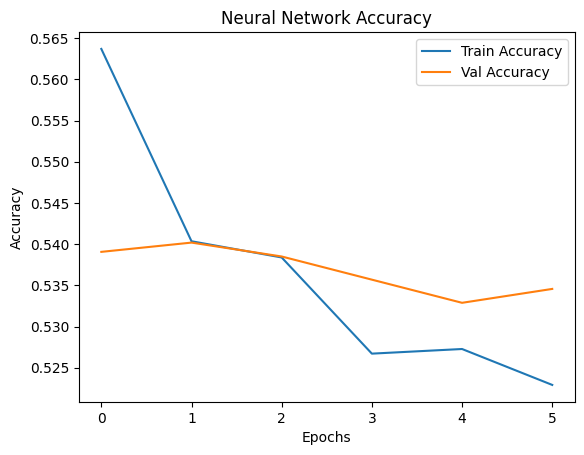

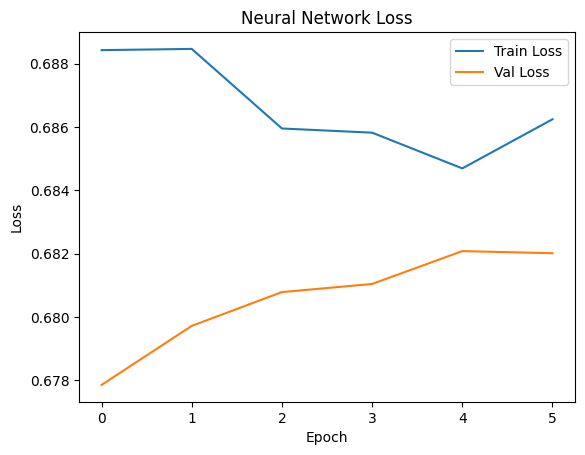

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5339 - loss: 0.6773
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.5295
Confusion Matrix:
 [[618 774]
 [272 559]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.44      0.54      1392
         1.0       0.42      0.67      0.52       831

    accuracy                           0.53      2223
   macro avg       0.56      0.56      0.53      2223
weighted avg       0.59      0.53      0.53      2223



In [13]:
import matplotlib.pyplot as plt

# Accuracy and loss curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Neural Network Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title("Neural Network Loss")
plt.show()

# Evaluation on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

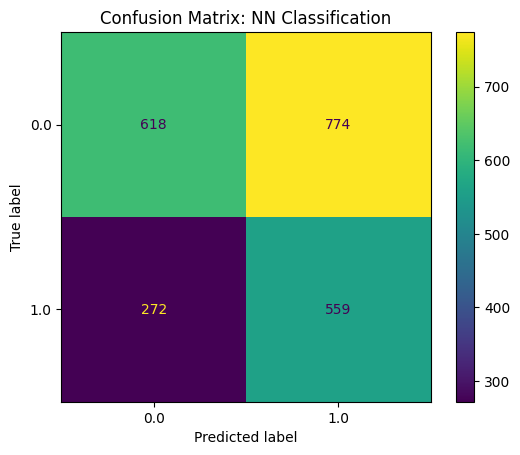

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix: NN Classification")
plt.show()

## __Model2 Building with Class Weights K-Fold with Keras + Keras Tuner__

In [15]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import keras_tuner as kt
import numpy as np

# === 1. Define the Model Builder ===
def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Choice('units1', [64, 128, 256]),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Optional second hidden layer
    if hp.Boolean('use_second_layer'):
        model.add(Dense(
            units=hp.Choice('units2', [32, 64, 128]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile with precision & recall tracking
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    return model

# === 2. Compute Class Weights ===
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# === 3. Set Up Keras Tuner ===
tuner = kt.RandomSearch(
    build_model,
    objective='val_precision',  # You can change this to 'val_auc' or 'val_recall'
    max_trials=10,
    executions_per_trial=1,
    directory='hyperband_dir',
    project_name='mortality_war_modeling'
)

# === 4. Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === 5. Hyperparameter Search ===
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Trial 10 Complete [00h 00m 21s]
val_precision: 0.4525139629840851

Best val_precision So Far: 0.610455334186554
Total elapsed time: 00h 07m 18s


In [16]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Rebuild the best model
best_model = build_model(best_hps)

# Retrain the model using the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5061 - loss: 0.9575 - precision: 0.3766 - recall: 0.4799 - val_accuracy: 0.4042 - val_loss: 0.7646 - val_precision: 0.3878 - val_recall: 0.9191
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4968 - loss: 0.8236 - precision: 0.3695 - recall: 0.5220 - val_accuracy: 0.5351 - val_loss: 0.6982 - val_precision: 0.4363 - val_recall: 0.6676
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5119 - loss: 0.8073 - precision: 0.3931 - recall: 0.5424 - val_accuracy: 0.5340 - val_loss: 0.6853 - val_precision: 0.4404 - val_recall: 0.7312
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5208 - loss: 0.8024 - precision: 0.4005 - recall: 0.5561 - val_accuracy: 0.5323 - val_loss: 0.6814 - val_precision: 0.4352 - val_recall: 0.6792
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5170 - loss: 0.7818 - precision: 0.3971 - recall: 0.5490 - val_accuracy: 0.5424 - val_loss: 0.

In [17]:
# Evaluate using F1
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score: 0.5159817351598174
              precision    recall  f1-score   support

         0.0     0.6921    0.4296    0.5301      1392
         1.0     0.4157    0.6799    0.5160       831

    accuracy                         0.5232      2223
   macro avg     0.5539    0.5548    0.5231      2223
weighted avg     0.5888    0.5232    0.5248      2223



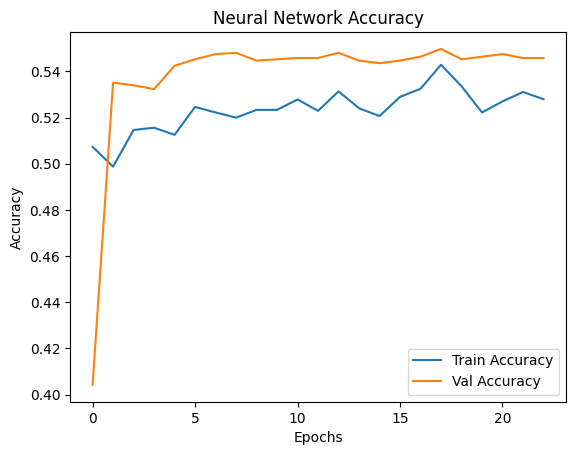

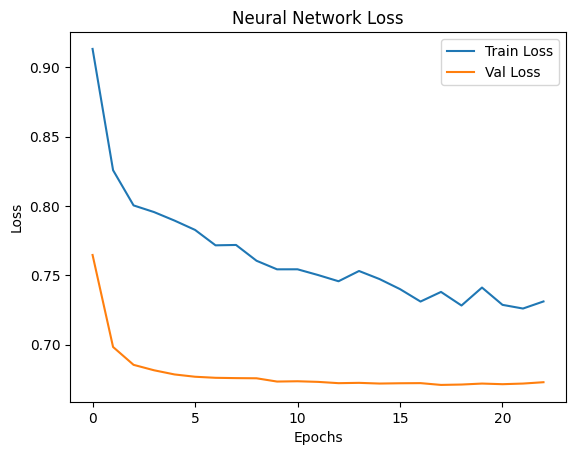


 Evaluation Metrics:
loss: 0.6748
compile_metrics: 0.5232
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Classification Report:
              precision    recall  f1-score   support

         0.0     0.6921    0.4296    0.5301      1392
         1.0     0.4157    0.6799    0.5160       831

    accuracy                         0.5232      2223
   macro avg     0.5539    0.5548    0.5231      2223
weighted avg     0.5888    0.5232    0.5248      2223



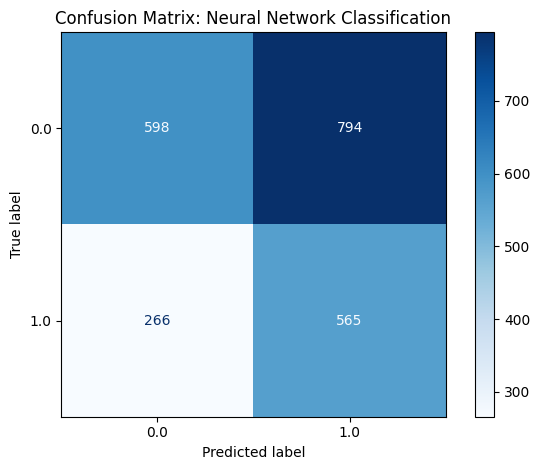

In [18]:
# Accuracy and loss curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Neural Network Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Neural Network Loss")
plt.show()

# === Evaluate model on test set ===
results = best_model.evaluate(X_test, y_test, verbose=0)
metric_names = best_model.metrics_names

# Create a mapping for pretty printing
print("\n Evaluation Metrics:")
for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")

# === Predict and threshold ===
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# === Classification Report ===
print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# === Confusion Matrix Plot ===
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: Neural Network Classification")
plt.tight_layout()
plt.show()

## __Model3 Building with Stratified K-Fold with Keras + Keras Tuner__

In [25]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Choice('units1', [64, 128, 256]),
        activation='relu',
        input_shape=(X.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    if hp.Boolean('use_second_layer'):
        model.add(Dense(
            units=hp.Choice('units2', [32, 64, 128]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),               #  This is required for val_auc to be logged
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

In [26]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import AUC

# === CONFIG ===
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store all F1-scores for final summary
f1_scores = []
conf_matrices = []

# === Stratified Cross-Validation Loop ===
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n Fold {fold + 1}/{n_splits}")

    # Split data
    X_train_fold, y_train_fold = X[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X[val_idx], y[val_idx]

    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=7,
        executions_per_trial=1,
        directory=f'kfold_tuning/fold_{fold}',
        project_name='mortality_war_modeling'
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Run tuner for this fold
    tuner.search(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Get best model for this fold
    best_model = tuner.get_best_models(1)[0]
    y_pred_probs = best_model.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Evaluate and store F1-score and confusion matrix
    score = f1_score(y_val_fold, y_pred)
    print(f"Fold {fold + 1} F1-score: {score:.4f}")
    f1_scores.append(score)

    cm = confusion_matrix(y_val_fold, y_pred)
    conf_matrices.append((fold + 1, cm))  # Store for later plotting

# === Final Performance Summary ===
print("\nCross-Validated F1-Scores:")
for i, s in enumerate(f1_scores):
    print(f"Fold {i + 1}: {s:.4f}")
print(f"Mean F1-score: {np.mean(f1_scores):.4f}")


 Fold 1/5
Reloading Tuner from kfold_tuning/fold_0/mortality_war_modeling/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 1 F1-score: 0.5569

 Fold 2/5
Reloading Tuner from kfold_tuning/fold_1/mortality_war_modeling/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 F1-score: 0.0000

 Fold 3/5
Reloading Tuner from kfold_tuning/fold_2/mortality_war_modeling/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 F1-score: 0.0000

 Fold 4/5
Reloading Tuner from kfold_tuning/fold_3/mortality_war_modeling/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4 F1-score: 0.2220

 Fold 5/5
Reloading Tuner from kfold_tuning/fold_4/mortality_war_modeling/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 5 F1-score: 0.4221

Cross-Validated F1-Scores:
Fold 1: 0.5569
Fold 2: 0.0000
Fold 3: 0.0000
Fold 4: 0.2220
Fold 5: 0.4221
Mean F1-score: 0.2402


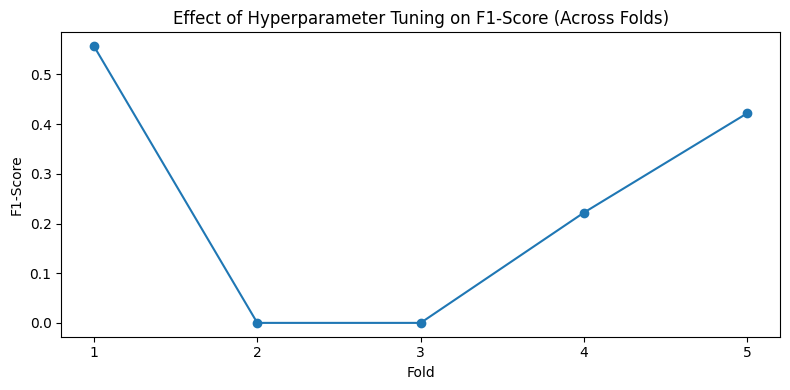

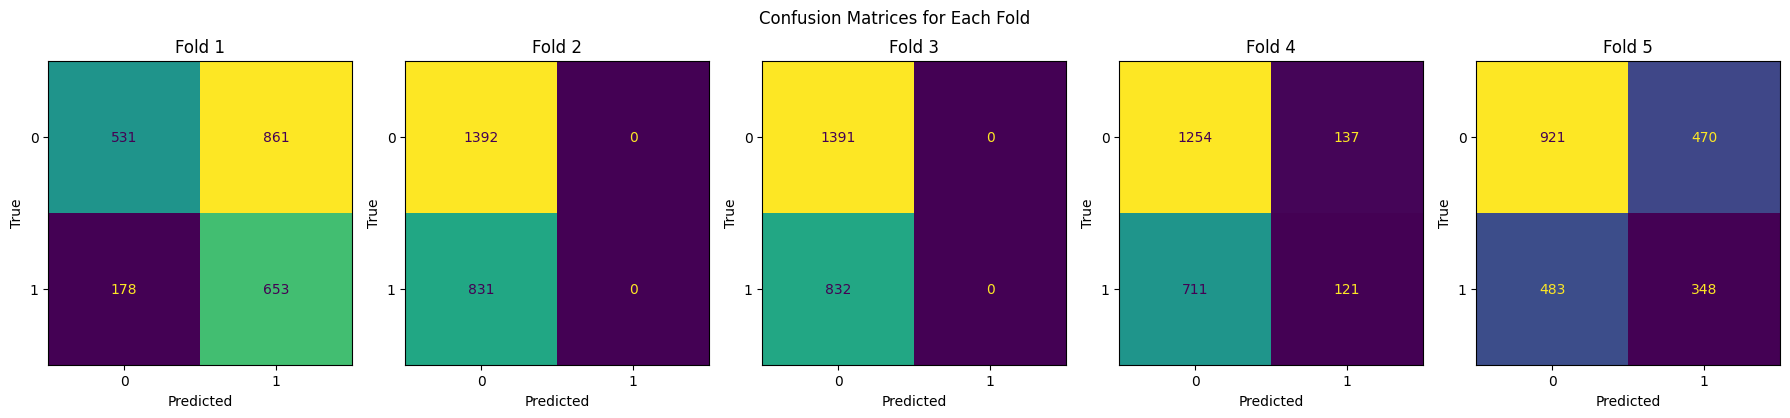

In [27]:
# === Plot F1-Scores ===
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_splits + 1), f1_scores, marker='o', linestyle='-')
plt.title("Effect of Hyperparameter Tuning on F1-Score (Across Folds)")
plt.xlabel("Fold")
plt.ylabel("F1-Score")
plt.xticks(range(1, n_splits + 1))
plt.grid(False)
plt.tight_layout()
plt.show()

# === Plot Confusion Matrices ===
fig, axs = plt.subplots(1, n_splits, figsize=(18, 4))
for i, (fold_num, cm) in enumerate(conf_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i], colorbar=False)
    axs[i].set_title(f"Fold {fold_num}")
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
plt.suptitle("Confusion Matrices for Each Fold")
plt.tight_layout()
plt.show()

## __Model4__


 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 F1-score: 0.0000

 Fold 2/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 2 F1-score: 0.3096

 Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 F1-score: 0.1538

 Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 F1-score: 0.0000

 Fold 5/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 5 F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


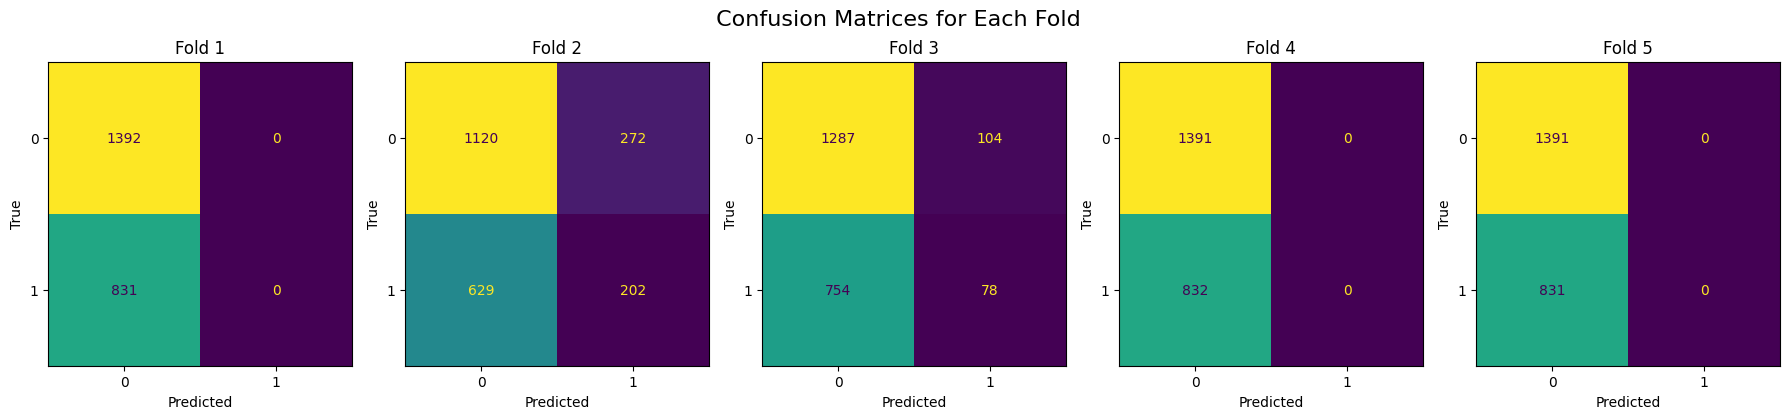

In [22]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# === CONFIG ===
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

def build_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    return model

# === Choose sampling strategy: "undersample", "smote", or "adasyn"
sampling_method = "undersample"  # Change to "undersample" or "adasyn" if needed
conf_matrices = []
f1_scores = []
all_reports = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n Fold {fold + 1}/{n_splits}")

    # === Split and resample
    X_train_fold, y_train_fold = X[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X[val_idx], y[val_idx]

    if sampling_method == "undersample":
        sampler = RandomUnderSampler(random_state=42)
    elif sampling_method == "smote":
        sampler = SMOTE(random_state=42)
    elif sampling_method == "adasyn":
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError("Invalid sampling method")

    X_resampled, y_resampled = sampler.fit_resample(X_train_fold, y_train_fold)

    # === Build and train model
    model = build_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_resampled, y_resampled,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # === Predict and evaluate
    y_pred_probs = model.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype(int)

    f1 = f1_score(y_val_fold, y_pred)
    f1_scores.append(f1)
    print(f"Fold {fold + 1} F1-score: {f1:.4f}")

    report = classification_report(y_val_fold, y_pred, digits=4, output_dict=True)
    all_reports.append(report)

# Store confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    conf_matrices.append((fold + 1, cm))

#  Plot confusion matrices after loop ===
fig, axs = plt.subplots(1, n_splits, figsize=(18, 4))  # Adjust width as needed
for i, (fold_num, cm) in enumerate(conf_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i], colorbar=False)
    axs[i].set_title(f"Fold {fold_num}")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("True")

plt.suptitle(" Confusion Matrices for Each Fold", fontsize=16)
plt.tight_layout()
plt.show()

## **K-Means Clustering Model**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_score = -1
best_k = None
best_model = None
for k in range(2, 6):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k}, Silhouette Score: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_model = model

print(f"Best K: {best_k}, Best Score: {best_score:.4f}")

K=2, Silhouette Score: 0.4684
K=3, Silhouette Score: 0.4666
K=4, Silhouette Score: 0.4732
K=5, Silhouette Score: 0.4449
Best K: 4, Best Score: 0.4732


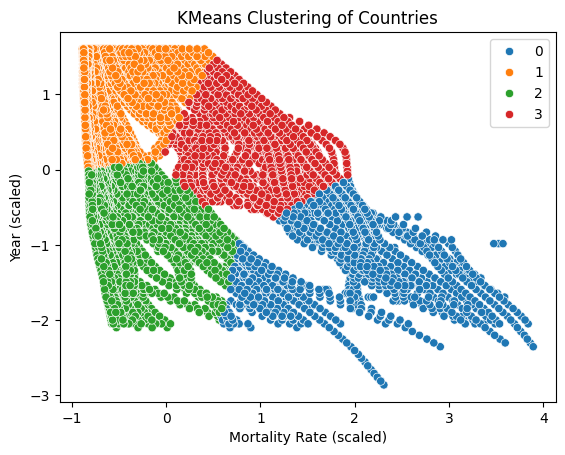

In [ ]:
import seaborn as sns

df_cleaned['Cluster'] = best_model.labels_
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=df_cleaned['Cluster'], palette='tab10')
plt.xlabel("Mortality Rate (scaled)")
plt.ylabel("Year (scaled)")
plt.title("KMeans Clustering of Countries")
plt.legend()
plt.show()

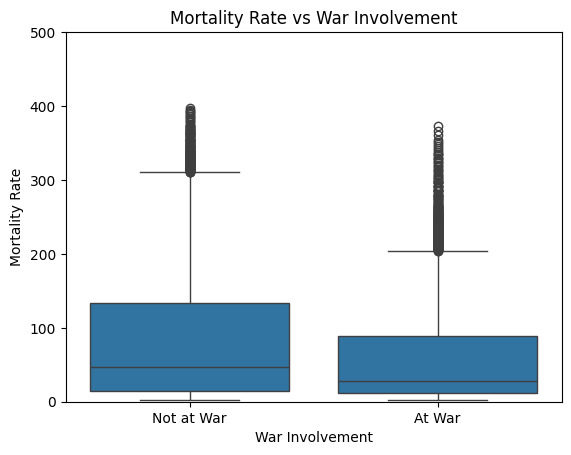

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='At war',
    y='Mortality_Rate',
    data=df_cleaned
)
plt.xticks([0, 1], ['Not at War', 'At War'])
plt.title("Mortality Rate vs War Involvement")
plt.ylabel("Mortality Rate")
plt.xlabel("War Involvement")
plt.ylim(0, 500)
plt.show()

<ipython-input-23-8051e8eba81c>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


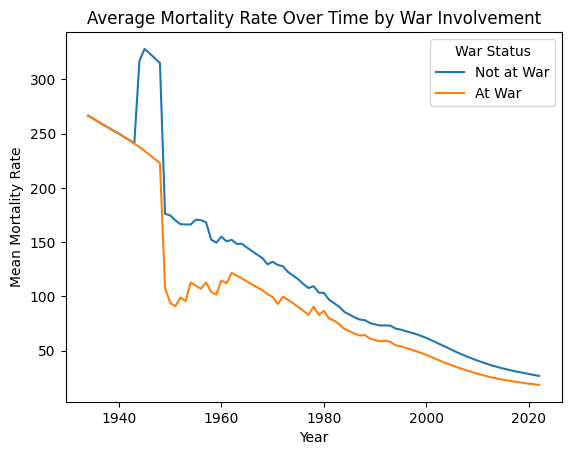

In [ ]:
sns.lineplot(
    data=df_cleaned,
    x='Year',
    y='Mortality_Rate',
    hue='At war',
    estimator='mean',
    ci=None
)
plt.legend(title="War Status", labels=["Not at War", "At War"])
plt.title("Average Mortality Rate Over Time by War Involvement")
plt.ylabel("Mean Mortality Rate")
plt.show()

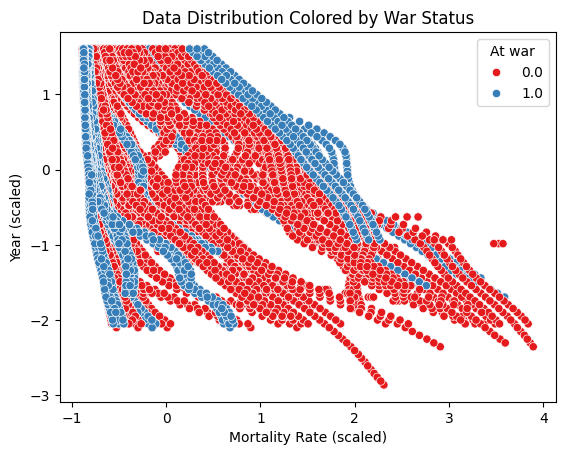

In [ ]:
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_cleaned['At war'],
    palette='Set1'
)
plt.xlabel("Mortality Rate (scaled)")
plt.ylabel("Year (scaled)")
plt.title("Data Distribution Colored by War Status")
plt.show()

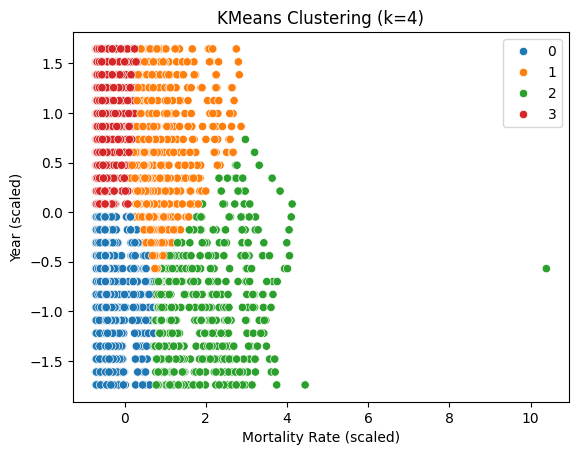

In [ ]:
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=best_model.labels_,
    palette='tab10'
)
plt.xlabel("Mortality Rate (scaled)")
plt.ylabel("Year (scaled)")
plt.title(f"KMeans Clustering (k={best_k})")
plt.show()


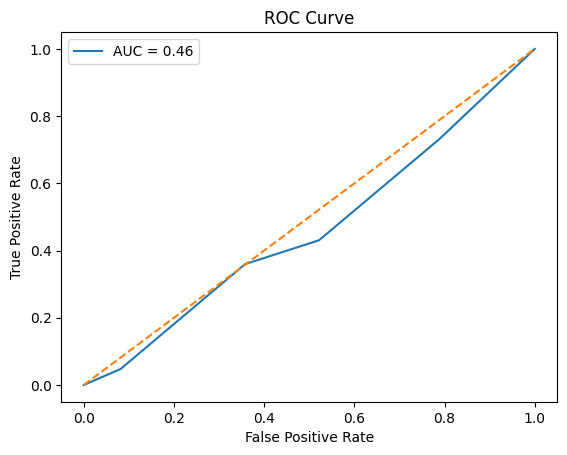

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


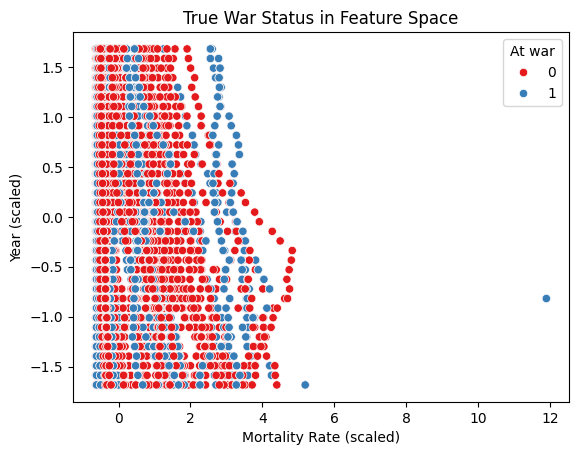

In [ ]:
import seaborn as sns
sns.scatterplot(
    x=X_scaled[:, 0], y=X_scaled[:, 1],
    hue=df_cleaned['At war'],
    palette='Set1'
)
plt.title("True War Status in Feature Space")
plt.xlabel("Mortality Rate (scaled)")
plt.ylabel("Year (scaled)")
plt.show()


In [ ]:
df_cleaned['Cluster'] = best_model.labels_
cluster_war_rate = df_cleaned.groupby('Cluster')['At war'].mean()
print(cluster_war_rate)


Cluster
0    0.388577
1    0.371844
2    0.242124
3    0.304435
Name: At war, dtype: float64
